In [69]:
!pip install nltk
import nltk

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [70]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, mean_squared_error, r2_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
import re
import matplotlib.pyplot as plt


In [71]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+|[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words("english")]
    return " ".join(tokens) if tokens else "empty"


In [72]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [73]:
class ClassificationNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

    def forward(self, x):
        return self.net(x)

In [74]:
def load_data(file, use_nlp=False, vectorizer=None, scaler=None, fit=True):
    df = pd.read_csv(file)
    df['sentiment'] = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
    df.dropna(inplace=True)
    y = df['sentiment'].values
    if 'candidate' not in df.columns:
        if 'train' in file:
            orig_file = 'train.csv'
        elif 'val' in file or 'valid' in file:
            orig_file = 'val.csv'
        elif 'test' in file:
            orig_file = 'test.csv'
        else:
            raise ValueError("Unknown dataset type. Cannot locate candidate column.")

        df_orig = pd.read_csv(orig_file)
        df['candidate'] = df_orig.loc[df.index, 'candidate']

    if use_nlp:
        df['clean_tweet'] = df['tweet_text'].apply(clean_text)
        if fit:
            vectorizer = TfidfVectorizer(max_features=5000)
            X_text = vectorizer.fit_transform(df['clean_tweet']).toarray()
        else:
            X_text = vectorizer.transform(df['clean_tweet']).toarray()
    else:
        X_text = np.array([]).reshape(len(df), 0)

    if 'candidate' in df.columns:
        X_num = df[['likes', 'retweets', 'candidate']].values
        candidate_values = X_num[:, -1]
        if fit:
            scaler = StandardScaler()
            X_num_scaled = scaler.fit_transform(X_num[:, :-1])
        else:
            X_num_scaled = scaler.transform(X_num[:, :-1])
        X = np.hstack((X_num_scaled, X_text)).astype(np.float32)
    else:
        X_num = df[['likes', 'retweets']].values
        candidate_values = []
        if fit:
            scaler = StandardScaler()
            X_num_scaled = scaler.fit_transform(X_num)
        else:
            X_num_scaled = scaler.transform(X_num)
        X = np.hstack((X_num_scaled, X_text)).astype(np.float32)

    return X, y, vectorizer, scaler, df, candidate_values


In [75]:
def train_model(X_train, y_train, X_val, y_val, X_test, y_test, input_dim, epochs=30, lr=0.001):
    model = ClassificationNN(input_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(SentimentDataset(X_train, y_train), batch_size=32, shuffle=True)

    train_losses, val_accuracies, test_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        with torch.no_grad():
            logits_val = model(torch.tensor(X_val, dtype=torch.float32))
            logits_test = model(torch.tensor(X_test, dtype=torch.float32))
            val_preds = torch.argmax(logits_val, dim=1).numpy()
            test_preds = torch.argmax(logits_test, dim=1).numpy()
            val_acc = np.mean(val_preds == y_val) * 100
            test_acc = np.mean(test_preds == y_test) * 100
            val_accuracies.append(val_acc)
            test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    return model, train_losses, val_accuracies, test_accuracies

In [76]:
def evaluate_model(model, X, y, candidates, file_name):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X, dtype=torch.float32))
        preds = torch.argmax(logits, dim=1).numpy()

    accuracy = accuracy_score(y, preds) * 100
    precision, recall, f1, _ = precision_recall_fscore_support(y, preds, average='weighted')
    rmse = mean_squared_error(y, preds)
    r2 = r2_score(y, preds)
    cm = confusion_matrix(y, preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {file_name}")
    plt.show()

    print(f"\nFinal Evaluation Metrics for {file_name}:")
    print(f"Accuracy: {accuracy:.2f}% | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}| MSE:{rmse:.4f}|R^2 error:{r2:.4f}")
    candidate_accuracy = {}
    if len(candidates) > 0:
        candidates = np.array(candidates)
        unique_candidates = np.unique(candidates)

        for candidate in unique_candidates:
            indices = np.where(candidates == candidate)[0]
            if len(indices) > 0:
                acc = accuracy_score(np.array(y)[indices], preds[indices]) * 100
                candidate_accuracy[candidate] = acc
                print(f"Accuracy for {candidate}: {acc:.2f}%")

        avg_candidate_accuracy = np.mean(list(candidate_accuracy.values()))
        print(f"Average Accuracy per Candidate: {avg_candidate_accuracy:.2f}%")
    else:
        avg_candidate_accuracy = None

    return accuracy, rmse, r2, candidate_accuracy, avg_candidate_accuracy,precision,recall,f1

In [77]:
def plot_training_curves(train_losses, val_accuracies,test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy per Epoch')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, test_accuracies, label='Test Accuracy', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy per Epoch')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [78]:
results = []
all_candidate_accuracies = {}
def run_and_store(label, train_file, val_file, test_file, use_nlp):
    print(f"\n== {label} ==")
    X_train, y_train, vectorizer, scaler, _, _ = load_data(train_file, use_nlp, fit=True)
    X_val, y_val, _, _, val_df, val_candidates = load_data(val_file, use_nlp, vectorizer, scaler, fit=False)
    X_test, y_test, _, _, test_df, test_candidates = load_data(test_file, use_nlp, vectorizer, scaler, fit=False)

    model, train_losses, val_accuracies, test_accuracies = train_model(X_train, y_train, X_val, y_val, X_test, y_test, input_dim=X_train.shape[1])

    acc_val, rmse_val, r2_val, val_cand_accs, avg_val_cand_acc,precision_val,recall_val,f1_val = evaluate_model(model, X_val, y_val, val_candidates, label + " - Validation")
    acc_test, rmse_test, r2_test, test_cand_accs, avg_test_cand_acc,precision_test,recall_test,f1_test = evaluate_model(model, X_test, y_test, test_candidates, label + " - Test")

    results.append({
        'Model': label,
        'Avg Candidate Accuracy': avg_test_cand_acc,
        'Precision': precision_test,
        'Recall': recall_test,
        'F1': f1_test
    })
    all_candidate_accuracies[label] = test_cand_accs
    plot_training_curves(train_losses, val_accuracies, test_accuracies)


== Unprocessed + NLP ==
Epoch 1/30, Loss: 1.0902, Val Accuracy: 86.00%
Epoch 2/30, Loss: 1.0207, Val Accuracy: 88.00%
Epoch 3/30, Loss: 0.9008, Val Accuracy: 88.00%
Epoch 4/30, Loss: 0.6949, Val Accuracy: 88.00%
Epoch 5/30, Loss: 0.4578, Val Accuracy: 88.00%
Epoch 6/30, Loss: 0.2863, Val Accuracy: 88.00%
Epoch 7/30, Loss: 0.2018, Val Accuracy: 100.00%
Epoch 8/30, Loss: 0.1645, Val Accuracy: 100.00%
Epoch 9/30, Loss: 0.1362, Val Accuracy: 100.00%
Epoch 10/30, Loss: 0.1075, Val Accuracy: 100.00%
Epoch 11/30, Loss: 0.0845, Val Accuracy: 100.00%
Epoch 12/30, Loss: 0.0620, Val Accuracy: 100.00%
Epoch 13/30, Loss: 0.0430, Val Accuracy: 100.00%
Epoch 14/30, Loss: 0.0316, Val Accuracy: 100.00%
Epoch 15/30, Loss: 0.0229, Val Accuracy: 100.00%
Epoch 16/30, Loss: 0.0178, Val Accuracy: 100.00%
Epoch 17/30, Loss: 0.0139, Val Accuracy: 100.00%
Epoch 18/30, Loss: 0.0112, Val Accuracy: 100.00%
Epoch 19/30, Loss: 0.0094, Val Accuracy: 100.00%
Epoch 20/30, Loss: 0.0081, Val Accuracy: 100.00%
Epoch 21/3

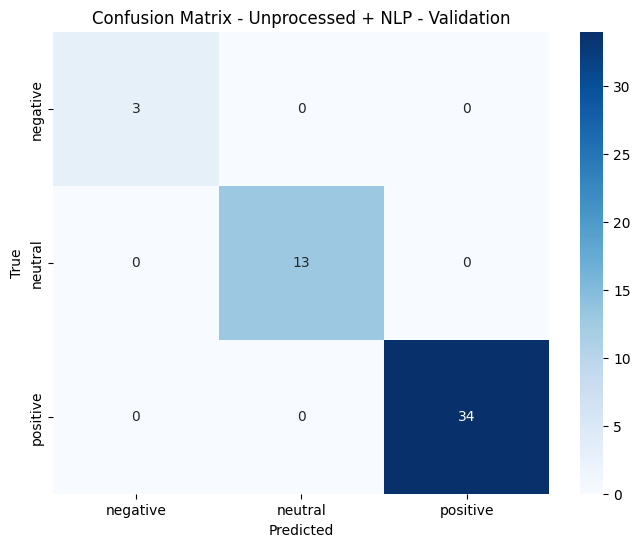


Final Evaluation Metrics for Unprocessed + NLP - Validation:
Accuracy: 100.00% | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000| MSE:0.0000|R^2 error:1.0000
Accuracy for Chase Oliver: 100.00%
Accuracy for Donald Trump: 100.00%
Accuracy for Jill Stein: 100.00%
Accuracy for Kamala Harris: 100.00%
Accuracy for Robert Kennedy: 100.00%
Average Accuracy per Candidate: 100.00%


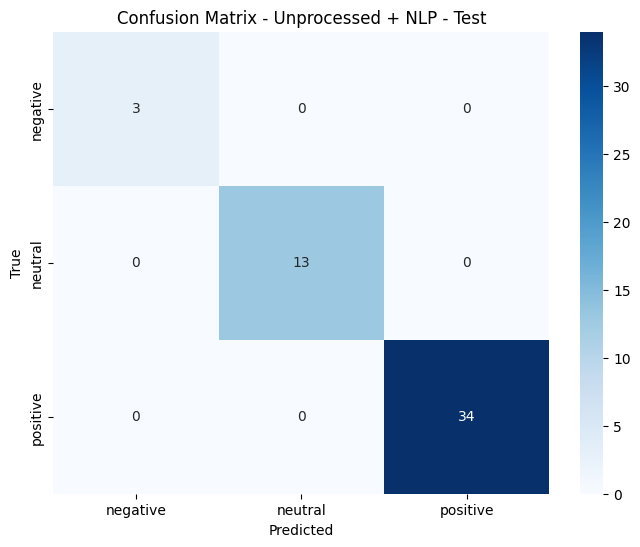


Final Evaluation Metrics for Unprocessed + NLP - Test:
Accuracy: 100.00% | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000| MSE:0.0000|R^2 error:1.0000
Accuracy for Chase Oliver: 100.00%
Accuracy for Donald Trump: 100.00%
Accuracy for Jill Stein: 100.00%
Accuracy for Kamala Harris: 100.00%
Accuracy for Robert Kennedy: 100.00%
Average Accuracy per Candidate: 100.00%


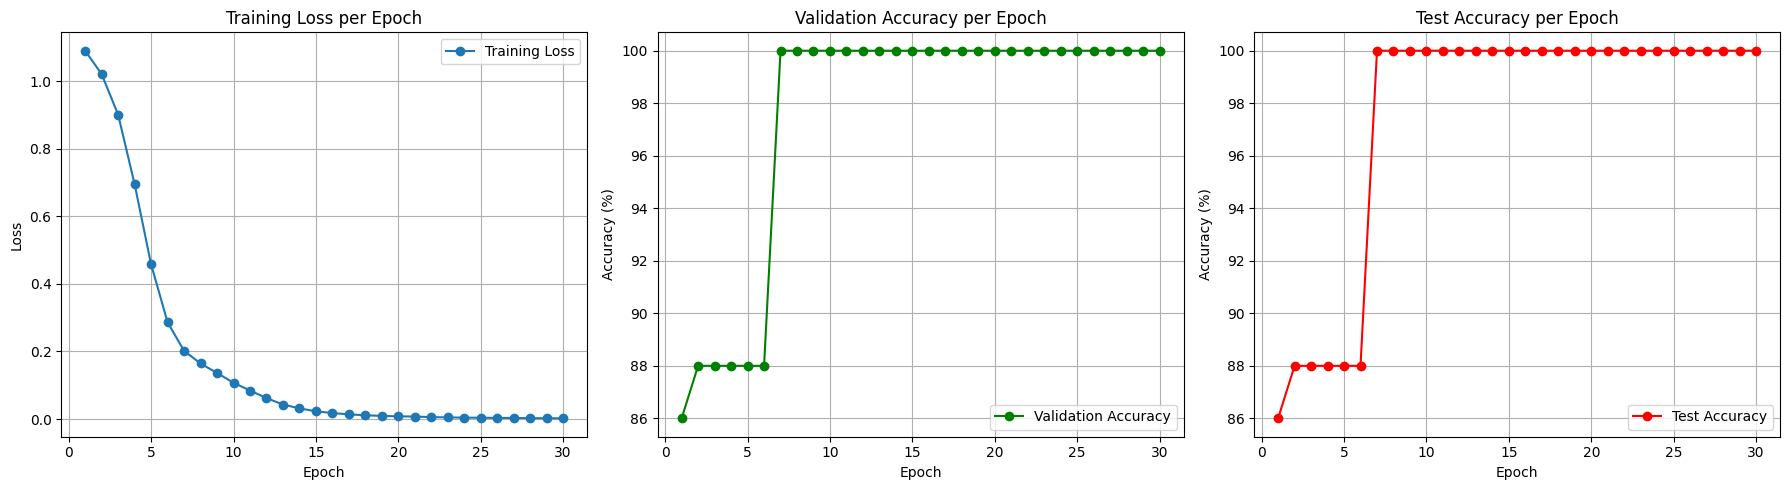


== Preprocessed + NLP ==
Epoch 1/30, Loss: 1.0245, Val Accuracy: 68.00%
Epoch 2/30, Loss: 0.9640, Val Accuracy: 68.00%
Epoch 3/30, Loss: 0.8430, Val Accuracy: 88.00%
Epoch 4/30, Loss: 0.6236, Val Accuracy: 88.00%
Epoch 5/30, Loss: 0.4014, Val Accuracy: 88.00%
Epoch 6/30, Loss: 0.2639, Val Accuracy: 88.00%
Epoch 7/30, Loss: 0.2075, Val Accuracy: 90.00%
Epoch 8/30, Loss: 0.1703, Val Accuracy: 96.00%
Epoch 9/30, Loss: 0.1444, Val Accuracy: 100.00%
Epoch 10/30, Loss: 0.1162, Val Accuracy: 100.00%
Epoch 11/30, Loss: 0.0898, Val Accuracy: 100.00%
Epoch 12/30, Loss: 0.0645, Val Accuracy: 100.00%
Epoch 13/30, Loss: 0.0431, Val Accuracy: 100.00%
Epoch 14/30, Loss: 0.0301, Val Accuracy: 100.00%
Epoch 15/30, Loss: 0.0223, Val Accuracy: 100.00%
Epoch 16/30, Loss: 0.0171, Val Accuracy: 100.00%
Epoch 17/30, Loss: 0.0139, Val Accuracy: 100.00%
Epoch 18/30, Loss: 0.0110, Val Accuracy: 100.00%
Epoch 19/30, Loss: 0.0090, Val Accuracy: 100.00%
Epoch 20/30, Loss: 0.0074, Val Accuracy: 100.00%
Epoch 21/30

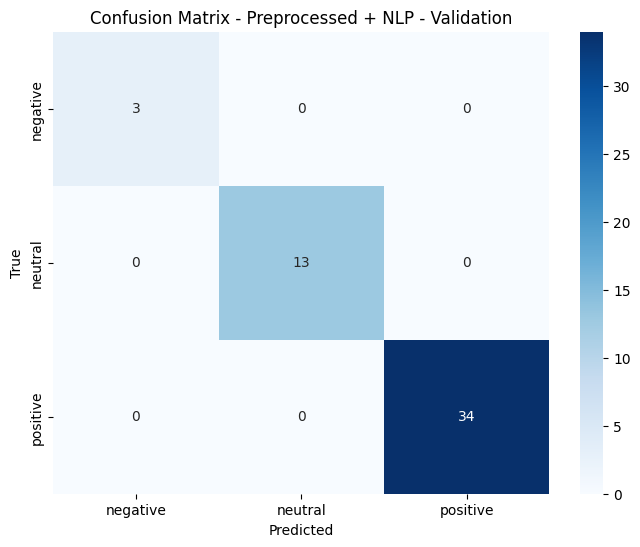


Final Evaluation Metrics for Preprocessed + NLP - Validation:
Accuracy: 100.00% | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000| MSE:0.0000|R^2 error:1.0000
Accuracy for Chase Oliver: 100.00%
Accuracy for Donald Trump: 100.00%
Accuracy for Jill Stein: 100.00%
Accuracy for Kamala Harris: 100.00%
Accuracy for Robert Kennedy: 100.00%
Average Accuracy per Candidate: 100.00%


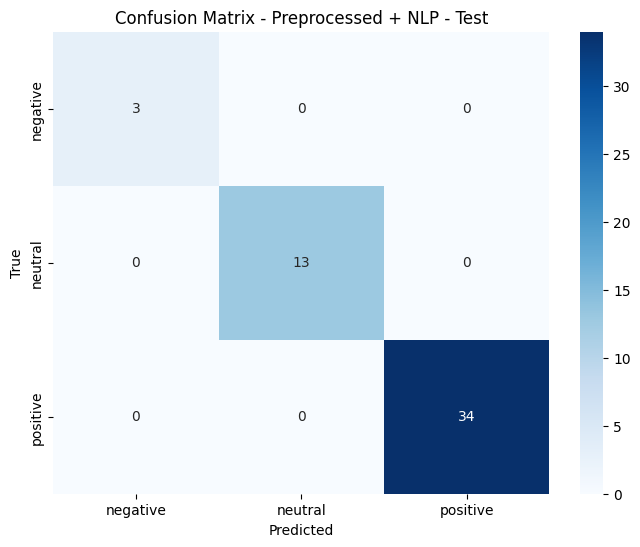


Final Evaluation Metrics for Preprocessed + NLP - Test:
Accuracy: 100.00% | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000| MSE:0.0000|R^2 error:1.0000
Accuracy for Chase Oliver: 100.00%
Accuracy for Donald Trump: 100.00%
Accuracy for Jill Stein: 100.00%
Accuracy for Kamala Harris: 100.00%
Accuracy for Robert Kennedy: 100.00%
Average Accuracy per Candidate: 100.00%


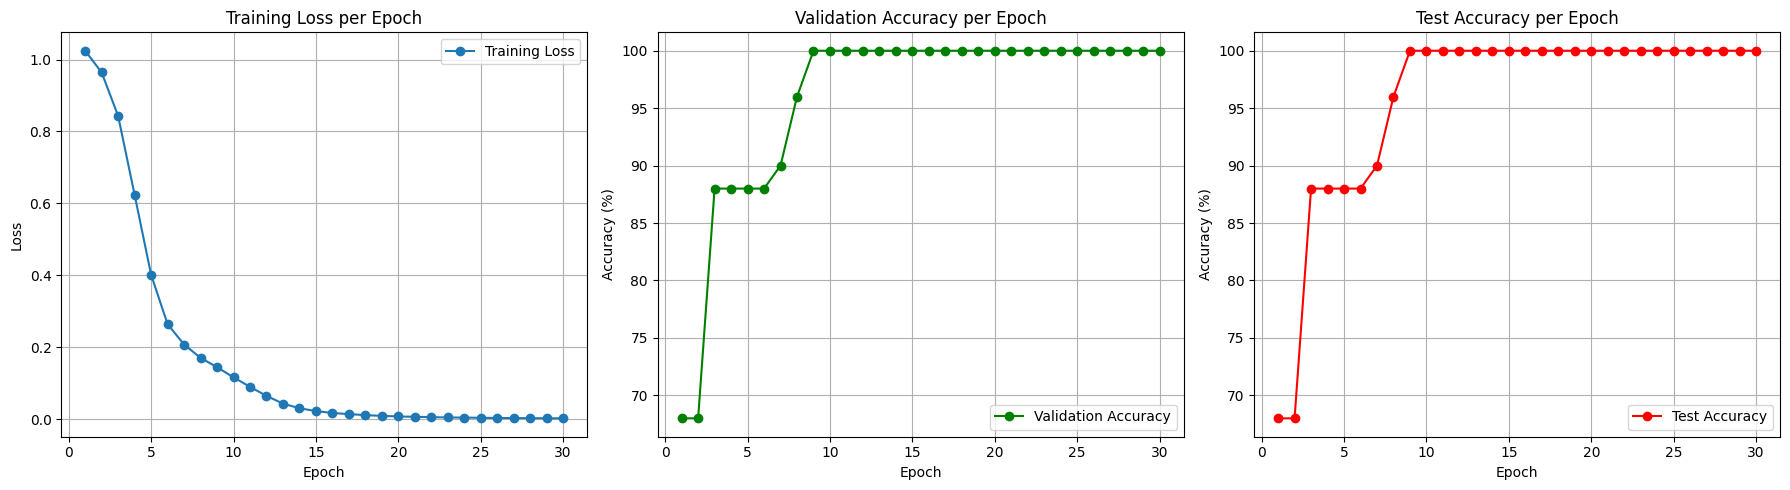


== Unprocessed - NLP ==
Epoch 1/30, Loss: 1.0564, Val Accuracy: 68.00%
Epoch 2/30, Loss: 0.8941, Val Accuracy: 68.00%
Epoch 3/30, Loss: 0.7616, Val Accuracy: 80.00%
Epoch 4/30, Loss: 0.6484, Val Accuracy: 88.00%
Epoch 5/30, Loss: 0.5471, Val Accuracy: 86.00%
Epoch 6/30, Loss: 0.4674, Val Accuracy: 88.00%
Epoch 7/30, Loss: 0.4042, Val Accuracy: 88.00%
Epoch 8/30, Loss: 0.3638, Val Accuracy: 88.00%
Epoch 9/30, Loss: 0.3328, Val Accuracy: 88.00%
Epoch 10/30, Loss: 0.3054, Val Accuracy: 88.00%
Epoch 11/30, Loss: 0.2938, Val Accuracy: 88.00%
Epoch 12/30, Loss: 0.2812, Val Accuracy: 86.00%
Epoch 13/30, Loss: 0.2717, Val Accuracy: 90.00%
Epoch 14/30, Loss: 0.2696, Val Accuracy: 88.00%
Epoch 15/30, Loss: 0.2633, Val Accuracy: 86.00%
Epoch 16/30, Loss: 0.2578, Val Accuracy: 86.00%
Epoch 17/30, Loss: 0.2568, Val Accuracy: 86.00%
Epoch 18/30, Loss: 0.2518, Val Accuracy: 86.00%
Epoch 19/30, Loss: 0.2461, Val Accuracy: 86.00%
Epoch 20/30, Loss: 0.2518, Val Accuracy: 90.00%
Epoch 21/30, Loss: 0.247

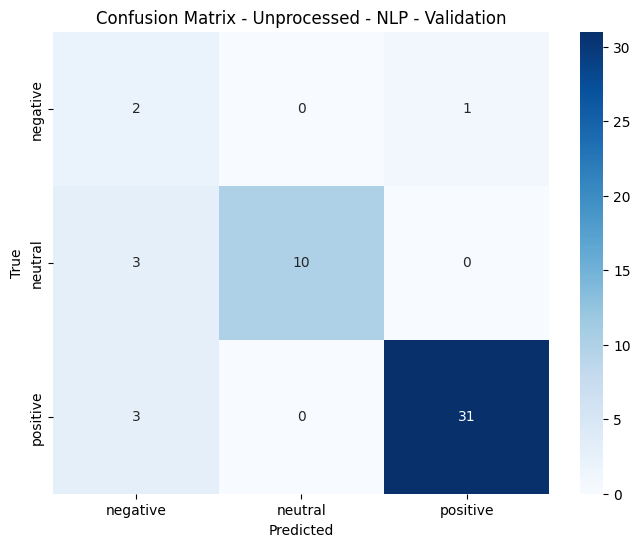


Final Evaluation Metrics for Unprocessed - NLP - Validation:
Accuracy: 86.00% | Precision: 0.9337 | Recall: 0.8600 | F1: 0.8867| MSE:0.3800|R^2 error:-0.0686
Accuracy for Chase Oliver: 100.00%
Accuracy for Donald Trump: 30.00%
Accuracy for Jill Stein: 100.00%
Accuracy for Kamala Harris: 100.00%
Accuracy for Robert Kennedy: 100.00%
Average Accuracy per Candidate: 86.00%


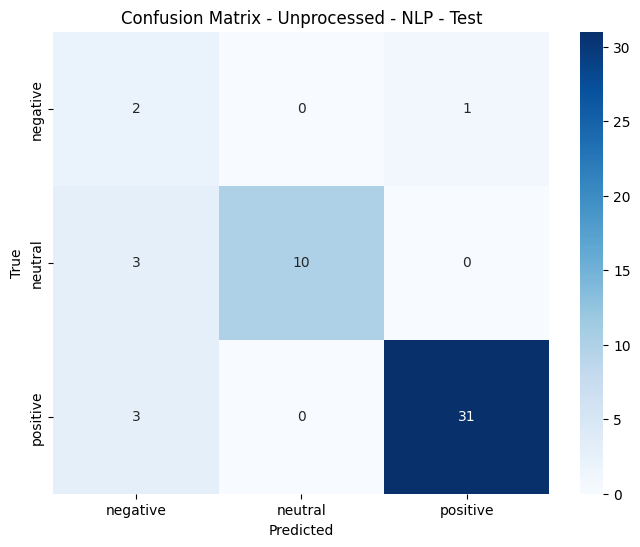


Final Evaluation Metrics for Unprocessed - NLP - Test:
Accuracy: 86.00% | Precision: 0.9337 | Recall: 0.8600 | F1: 0.8867| MSE:0.3800|R^2 error:-0.0686
Accuracy for Chase Oliver: 100.00%
Accuracy for Donald Trump: 30.00%
Accuracy for Jill Stein: 100.00%
Accuracy for Kamala Harris: 100.00%
Accuracy for Robert Kennedy: 100.00%
Average Accuracy per Candidate: 86.00%


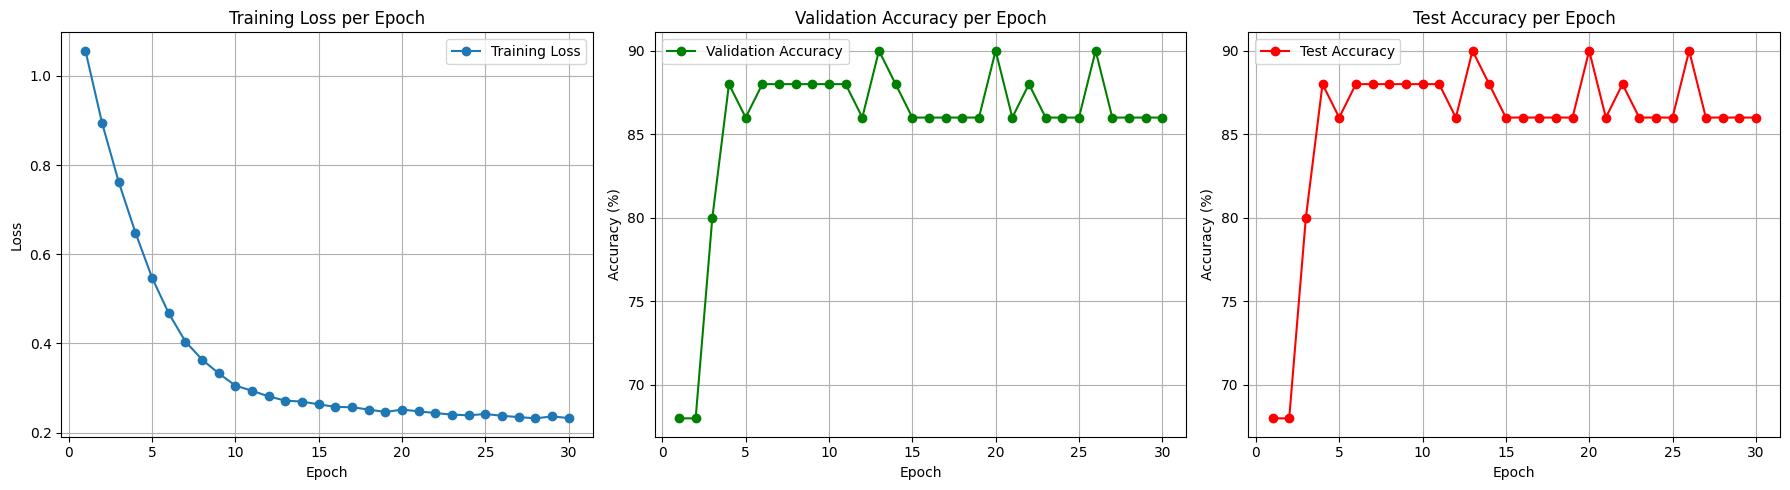


== Preprocessed - NLP ==
Epoch 1/30, Loss: 0.9978, Val Accuracy: 68.00%
Epoch 2/30, Loss: 0.8739, Val Accuracy: 68.00%
Epoch 3/30, Loss: 0.7725, Val Accuracy: 68.00%
Epoch 4/30, Loss: 0.6800, Val Accuracy: 80.00%
Epoch 5/30, Loss: 0.5776, Val Accuracy: 88.00%
Epoch 6/30, Loss: 0.4976, Val Accuracy: 88.00%
Epoch 7/30, Loss: 0.4267, Val Accuracy: 88.00%
Epoch 8/30, Loss: 0.3894, Val Accuracy: 88.00%
Epoch 9/30, Loss: 0.3464, Val Accuracy: 86.00%
Epoch 10/30, Loss: 0.3241, Val Accuracy: 90.00%
Epoch 11/30, Loss: 0.3064, Val Accuracy: 86.00%
Epoch 12/30, Loss: 0.2962, Val Accuracy: 86.00%
Epoch 13/30, Loss: 0.2858, Val Accuracy: 86.00%
Epoch 14/30, Loss: 0.2763, Val Accuracy: 86.00%
Epoch 15/30, Loss: 0.2711, Val Accuracy: 90.00%
Epoch 16/30, Loss: 0.2635, Val Accuracy: 86.00%
Epoch 17/30, Loss: 0.2620, Val Accuracy: 86.00%
Epoch 18/30, Loss: 0.2563, Val Accuracy: 86.00%
Epoch 19/30, Loss: 0.2565, Val Accuracy: 90.00%
Epoch 20/30, Loss: 0.2543, Val Accuracy: 86.00%
Epoch 21/30, Loss: 0.24

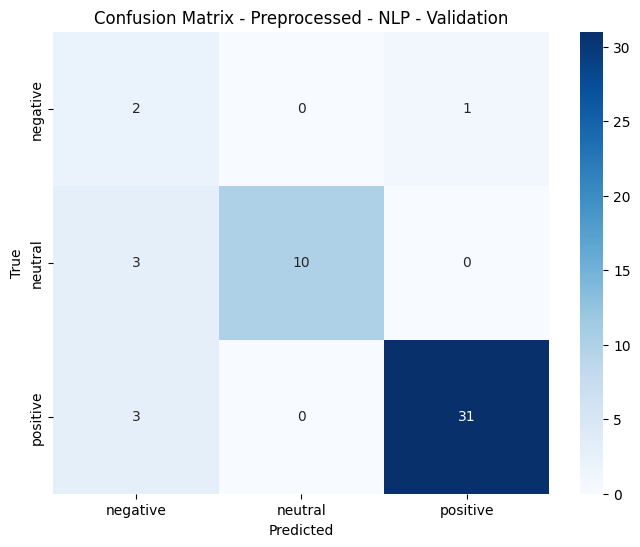


Final Evaluation Metrics for Preprocessed - NLP - Validation:
Accuracy: 86.00% | Precision: 0.9337 | Recall: 0.8600 | F1: 0.8867| MSE:0.3800|R^2 error:-0.0686
Accuracy for Chase Oliver: 100.00%
Accuracy for Donald Trump: 30.00%
Accuracy for Jill Stein: 100.00%
Accuracy for Kamala Harris: 100.00%
Accuracy for Robert Kennedy: 100.00%
Average Accuracy per Candidate: 86.00%


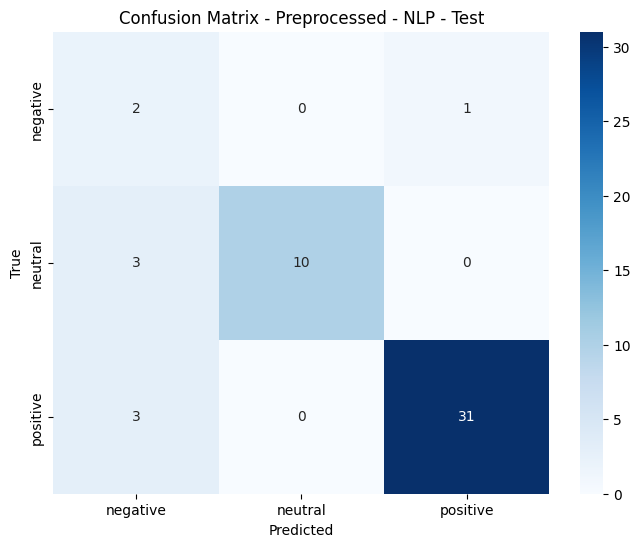


Final Evaluation Metrics for Preprocessed - NLP - Test:
Accuracy: 86.00% | Precision: 0.9337 | Recall: 0.8600 | F1: 0.8867| MSE:0.3800|R^2 error:-0.0686
Accuracy for Chase Oliver: 100.00%
Accuracy for Donald Trump: 30.00%
Accuracy for Jill Stein: 100.00%
Accuracy for Kamala Harris: 100.00%
Accuracy for Robert Kennedy: 100.00%
Average Accuracy per Candidate: 86.00%


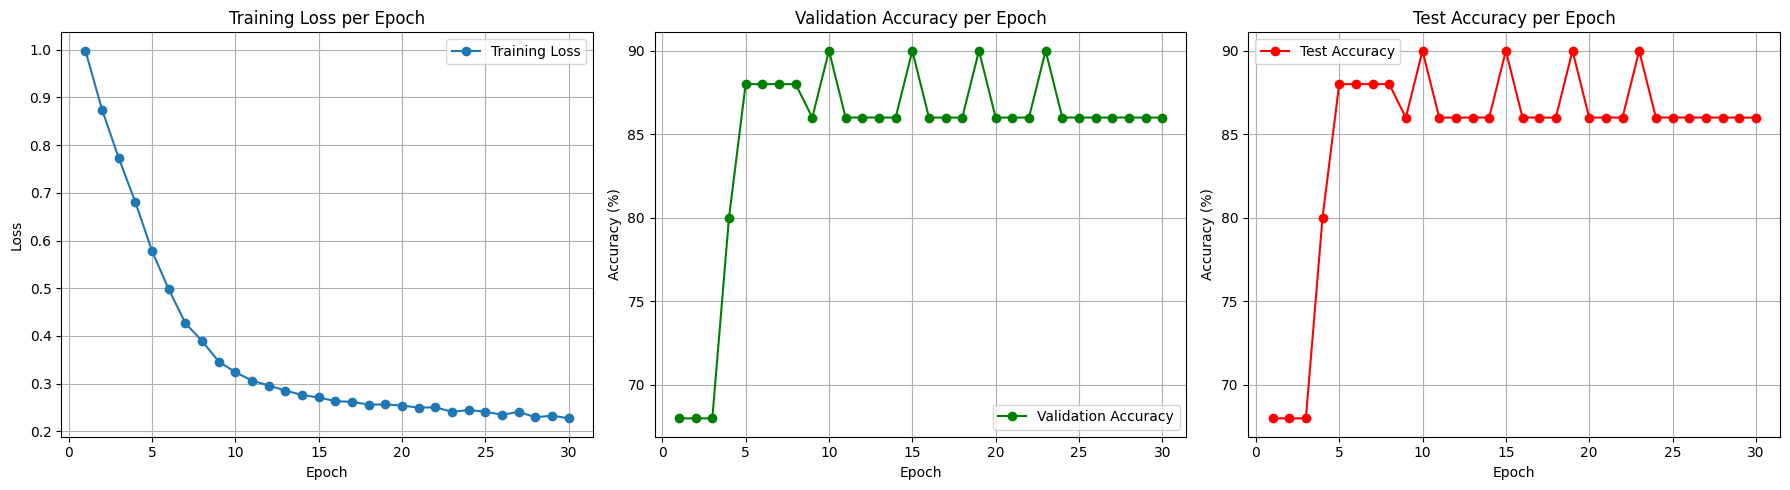

In [79]:
run_and_store("Unprocessed + NLP", "train.csv", "val.csv", "test.csv", use_nlp=True)
run_and_store("Preprocessed + NLP", "train_preprocessed.csv", "val_preprocessed.csv", "test_preprocessed.csv", use_nlp=True)
run_and_store("Unprocessed - NLP", "train.csv", "val.csv", "test.csv", use_nlp=False)
run_and_store("Preprocessed - NLP", "train_preprocessed.csv", "val_preprocessed.csv", "test_preprocessed.csv", use_nlp=False)

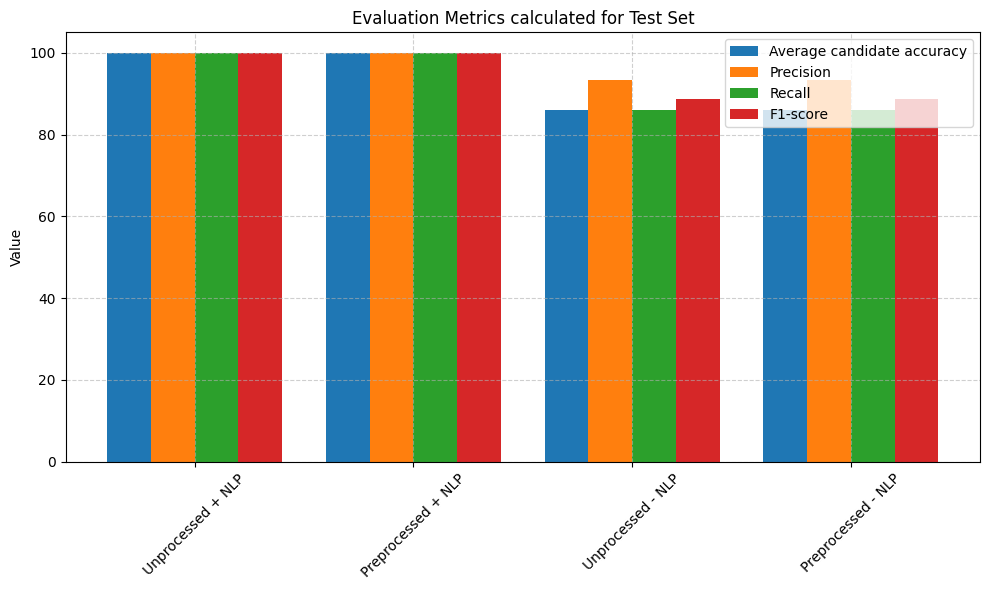

In [80]:
metrics_df = pd.DataFrame(results)
metrics_df.to_csv("NNClassification_EvaluationMetrics.csv", index=False)

plt.figure(figsize=(10, 6))
bar_width = 0.2
x = np.arange(len(metrics_df))

plt.bar(x - bar_width*1.5, metrics_df['Avg Candidate Accuracy'], width=bar_width, label='Average candidate accuracy')
plt.bar(x - bar_width/2, metrics_df['Precision']*100, width=bar_width, label='Precision')
plt.bar(x + bar_width/2, metrics_df['Recall']*100, width=bar_width, label='Recall')
plt.bar(x + bar_width*1.5, metrics_df['F1']*100, width=bar_width, label='F1-score')

plt.xticks(x, metrics_df['Model'], rotation=45)
plt.ylabel("Value")
plt.title("Evaluation Metrics calculated for Test Set")
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [81]:
def plot_all_candidate_accuracies(all_cand_accs):
    print("\n=== Candidate-wise Accuracy by Dataset ===")
    all_candidates = sorted(set(c for d in all_cand_accs.values() for c in d))

    header = ["Candidate"] + list(all_cand_accs.keys())
    row_format = "{:<15}" + "{:<15}" * len(all_cand_accs)
    print(row_format.format(*header))

    for candidate in all_candidates:
        row = [candidate]
        for dataset in all_cand_accs:
            acc = all_cand_accs[dataset].get(candidate, "N/A")
            row.append(f"{acc:.2f}%" if isinstance(acc, float) else acc)
        print(row_format.format(*row))

    x = np.arange(len(all_candidates))
    width = 0.8 / len(all_cand_accs)

    plt.figure(figsize=(10, 6))
    for i, (label, acc_dict) in enumerate(all_cand_accs.items()):
        accs = [acc_dict.get(candidate, 0) for candidate in all_candidates]
        plt.bar(x + i * width, accs, width=width, label=label)

    plt.xlabel("Candidate")
    plt.ylabel("Accuracy (%)")
    plt.title("Candidate-wise Test Accuracy Across Datasets")
    plt.xticks(x + width * (len(all_cand_accs) - 1) / 2, all_candidates, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


=== Candidate-wise Accuracy by Dataset ===
Candidate      Unprocessed + NLPPreprocessed + NLPUnprocessed - NLPPreprocessed - NLP
Chase Oliver   100.00%        100.00%        100.00%        100.00%        
Donald Trump   100.00%        100.00%        30.00%         30.00%         
Jill Stein     100.00%        100.00%        100.00%        100.00%        
Kamala Harris  100.00%        100.00%        100.00%        100.00%        
Robert Kennedy 100.00%        100.00%        100.00%        100.00%        


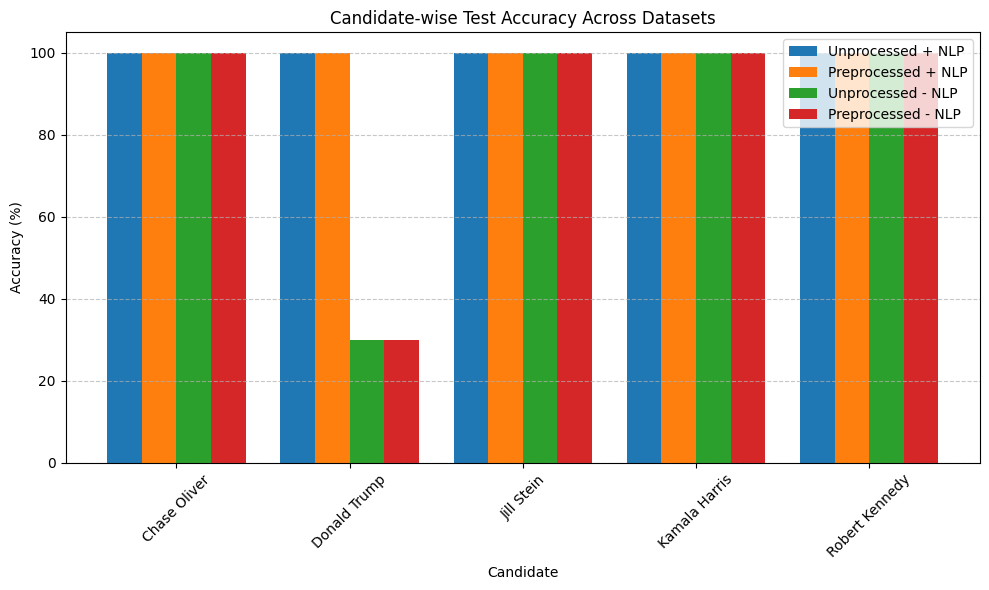

In [82]:
plot_all_candidate_accuracies(all_candidate_accuracies)